In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np

#from torch.optim.lr_scheduler import StepLR
import torch.optim as optim


In [2]:
print('torch version:',torch.__version__)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('device:', device)
else:
    device = torch.device("cpu")
    print('CUDA is not available. Using CPU.')

torch version: 2.4.1+cu124
device: cuda


https://scholar.harvard.edu/files/schwartz/files/lecture3-coupled-oscillators.pdf

Solve two coupled harmonic oscillators:
\begin{align}
m \, \partial_t^2 \, x_{1} + (k + \kappa) \, x_1 - \kappa \, x_2 &= 0
\,,
\\
m \, \partial_t^2 \, x_{2} + (k + \kappa) \, x_2 - \kappa \, x_1 &= 0
\,.
\end{align}     

The analytical solution is
\begin{align}
x_1(t) &= \frac{1}{2} \left[ A_s \cos\left(\omega_s t + \phi_s \right) + A_f \cos\left(\omega_f t + \phi_f \right) \right]
\\
x_2(t) &= \frac{1}{2} \left[ A_s \cos\left(\omega_s t + \phi_s \right) - A_f \cos\left(\omega_f t + \phi_f \right) \right]
\end{align}
with
\begin{align}
\omega_s = \sqrt{k/m} \,, \quad \omega_f = \sqrt{(k+2\kappa)/m}
\,.
\end{align}

We solve the problem in the domain $t \in [0,T]$ with initial conditions at $t=0$
\begin{align}
x_1(t=0)=\frac{1}{2} \left[ A_s \cos\left(\phi_s \right) + A_f \cos\left(\phi_f \right) \right]
\,, \quad
\partial_t \, x_1(t=0)=\frac{1}{2} \left[ \omega_s A_s \sin\left(\phi_s \right) + \omega_f A_f \sin\left(\phi_f \right) \right]
\,, \\
x_2(t=0)=\frac{1}{2} \left[ A_s \cos\left(\phi_s \right) - A_f \cos\left(\phi_f \right) \right]
\,, \quad 
\partial_t \, x_2(t=0)=\frac{1}{2} \left[ \omega_s A_s \sin\left(\phi_s \right) - \omega_f A_f \sin\left(\phi_f \right) \right]
\,.
\end{align}

Define the neural network:

In [3]:
# copied from https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
class FCN(torch.nn.Module):    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        
        self.fcs = torch.nn.Sequential(*[
                        torch.nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = torch.nn.Sequential(*[
                        torch.nn.Sequential(*[
                            torch.nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)

      # Apply custom weight initialization
        self.apply(self._init_weights)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

    def _init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            # Get the size of the previous layer (input size of the current layer)
            n = m.in_features # The number of input features to this layer
            # Set the range for uniform distribution as [-1/sqrt(n), 1/sqrt(n)]
            bound = 1 / np.sqrt(n)
            # Initialize weights with a uniform distribution in the range [-bound, bound]
            torch.nn.init.uniform_(m.weight, -bound, bound)
            
            # Initialize biases to zero, only if the layer has biases
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)

In [4]:
# copied from https://github.com/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

In [5]:
def domain_loss(u, t, m, k, kappa):
    # from https://github.com/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb
    x1, x2 = map(lambda i:  u[:,[i]], range(2))
    # take derivatives
    x1tt = gradients(x1, t, order=2)
    x2tt = gradients(x2, t, order=2)
    
    #eq x1
    eq_x1 = m*x1tt + (k+kappa)*x1 - kappa*x2
    #eq x2
    eq_x2 = m*x2tt + (k+kappa)*x2 - kappa*x1

    loss_dom = torch.mean(torch.pow(eq_x1,2)) + torch.mean(torch.pow(eq_x2,2))
    return loss_dom

def t0_loss(u, t, m, k, kappa, 
            # below: amplitudes and phases
            As, Af, phis, phif):
    # from https://github.com/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb
    x1, x2 = map(lambda i:  u[[i]], range(2))
    # take derivatives
    x1t = gradients(x1, t, order=1)
    x2t = gradients(x2, t, order=1)

    # omegas
    omegas = torch.sqrt(k/m)
    # omegaf
    omegaf = torch.sqrt((k+2.0*kappa)/m)
    # ic_x1
    ic_x1 = 0.5*(As*torch.cos(phis) + Af*torch.cos(phif))
    # ic_x2
    ic_x2 = 0.5*(As*torch.cos(phis) - Af*torch.cos(phif))
    # ic_x1t
    ic_x1t = -0.5*(omegas*As*torch.sin(phis) + omegaf*Af*torch.sin(phif))
    # ic_x2t
    ic_x2t = -0.5*(omegas*As*torch.sin(phis) - omegaf*Af*torch.sin(phif))
    
    loss_ic_x1 = torch.mean(torch.pow(ic_x1 - x1,2))
    loss_ic_x2 = torch.mean(torch.pow(ic_x2 - x2,2))
    loss_ic_x1t = torch.mean(torch.pow(ic_x1t - x1t,2))
    loss_ic_x2t = torch.mean(torch.pow(ic_x2t - x2t,2))
    return loss_ic_x1, loss_ic_x2, loss_ic_x1t, loss_ic_x2t

In [6]:
# random (uniform) sample points
#def random_domain_points(tmax,n, epsilon):
#    t = tmax*torch.rand((n,1), requires_grad=True).to(device) + epsilon*torch.ones((n,1), requires_grad=True).to(device)
#    return t
def random_domain_points(n):
    t = torch.rand((n,1), requires_grad=True)
    return t

In [7]:
#torch.manual_seed(42)

# set the model
# input, output, neurons, hidden layers
model = FCN(1,2,64,3).to(device)

# optimizer and initialization of parameters (weights and biases)
#optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
# true also below
#scheduler = StepLR(optimizer, step_size=1000, gamma=0.25, verbose=False)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


In [8]:
# harmonic oscillators' params
m = 1.0*torch.ones(1).to(device); # mass
k = 2.0*torch.ones(1).to(device); # spring constant
kappa = 5.0*torch.ones(1).to(device); # spring constant
As = 1.0*torch.ones(1).to(device); # amplitude
phis = 0.5*torch.pi*torch.ones(1).to(device) # initial phase
Af = 1.0*torch.ones(1).to(device); # amplitude
phif = 0.5*torch.pi*torch.ones(1).to(device) # initial phase
T = 5.0*torch.ones(1).to(device) # tmax

In [9]:
n = 200 # number of random sampling points

epochs = 20000
gamma1 = 10.0
gamma2 = 10.0
#epsilon = 1e-3

loss_list = []

for epoch in range(int(epochs)):
    optimizer.zero_grad() # to make the gradients zero
    # sample time ponts
    t = T*random_domain_points(n).to(device) #random_domain_points(T, n, epsilon)
    # get the solution
    u = model(t)
    # loss in bulk of the domain
    loss_dom = domain_loss(u, t, m, k, kappa)
    # loss for initial data
    # sol for x(t=0)
    t0 = torch.zeros(1, requires_grad=True).to(device)
    u0 = model(t0) # solution of x(t=0)
    loss_ic_x1, loss_ic_x2, loss_ic_x1t, loss_ic_x2t = t0_loss(u0, t0, m, k, kappa, As, Af, phis, phif)
    # LOSS
    loss = loss_dom + gamma2*(loss_ic_x1t + loss_ic_x2t) + gamma1*(loss_ic_x1 + loss_ic_x2)
    loss_list.append(loss.cpu().detach().numpy()) 
    # print message
    print('epoch = ', epoch, '| loss = ', loss.item(), '|',  end='\r')
    # detach() removes the "requires_grad" and numpy() makes it a numpy item to plot later
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # 


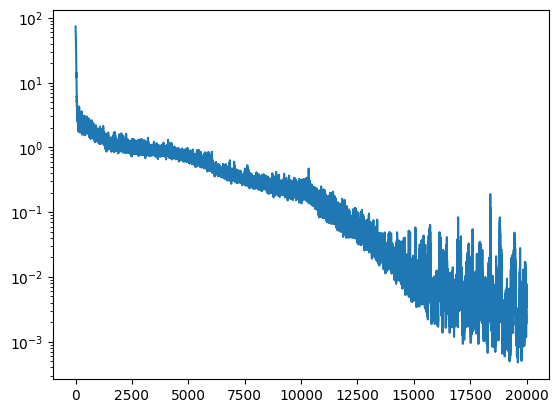

In [10]:
plt.semilogy(loss_list)

The analytical solution is
\begin{align}
x_1(t) &= \frac{1}{2} \left[ A_s \cos\left(\omega_s t + \phi_s \right) + A_f \cos\left(\omega_f t + \phi_f \right) \right]
\\
x_2(t) &= \frac{1}{2} \left[ A_s \cos\left(\omega_s t + \phi_s \right) - A_f \cos\left(\omega_f t + \phi_f \right) \right]
\end{align}
with
\begin{align}
\omega_s = \sqrt{k/m} \,, \quad \omega_f = \sqrt{(k+2\kappa)/m}
\,.
\end{align}

In [11]:
# the analytical solution
def analytical_sol(t, m, k, kappa, As, Af, phis, phif):
    omegas = np.sqrt(k/m)
    omegaf = np.sqrt((k+2*kappa)/m)
    x1 = 0.5*(As*np.cos(omegas*t + phis) + Af*np.cos(omegaf*t + phif))
    x2 = 0.5*(As*np.cos(omegas*t + phis) - Af*np.cos(omegaf*t + phif))
    return x1, x2

In [12]:
# the time domain; used to visualize the analytical solution
T1 = T.item() # tmax
N = 100
t = torch.linspace(0,T1,N)#.view(-1,10)
#print(t)

# the view(-1,1) make the row tensor to a column tensor
# -1 means you dont know how many rows you need, and 1 mean that you want 1 element in each row
t = torch.linspace(0,T1,100).view(-1,1).to(device)

nn_sol = model(t).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot


In [13]:
x1_nn, x2_nn = map(lambda i:  nn_sol[:,[i]], range(2))
x1_an, x2_an = analytical_sol(t.cpu().detach().numpy(), m.cpu().detach().numpy(), k.cpu().detach().numpy(),
                              kappa.cpu().detach().numpy(), As.cpu().detach().numpy(), Af.cpu().detach().numpy(),
                              phis.cpu().detach().numpy(), phif.cpu().detach().numpy())

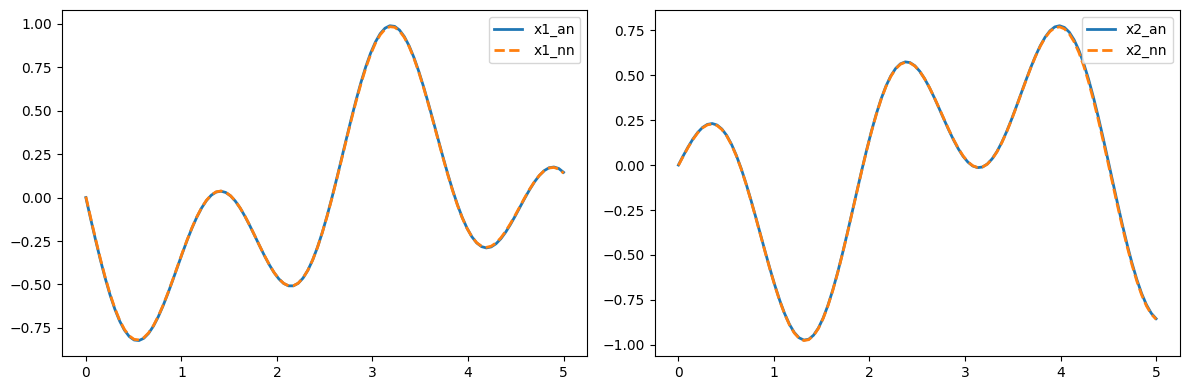

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4));

ax1.cla()
ax1.plot(t.cpu(), x1_an, label="x1_an", lw=2)
ax1.plot(t.cpu(), x1_nn, label="x1_nn", lw=2, ls='--')
ax1.legend(loc='upper right')

ax2.cla()
ax2.plot(t.cpu(), x2_an, label="x2_an", lw=2)
ax2.plot(t.cpu(), x2_nn, label="x2_nn", lw=2, ls='--')
ax2.legend(loc='upper right')

plt.tight_layout()